特徵數量: 42
訓練集大小: (46910, 42)
驗證集大小: (11728, 42)
測試集大小: (14660, 42)
開始訓練模型...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 6.8323010	test: 6.9914073	best: 6.9914073 (0)	total: 76.2ms	remaining: 1m 16s
100:	learn: 0.4834341	test: 0.5624546	best: 0.5624546 (100)	total: 2.18s	remaining: 19.4s
200:	learn: 0.4053770	test: 0.4946117	best: 0.4946117 (200)	total: 3.9s	remaining: 15.5s
300:	learn: 0.3426838	test: 0.4298272	best: 0.4298272 (300)	total: 5.82s	remaining: 13.5s
400:	learn: 0.2946428	test: 0.3815827	best: 0.3815827 (400)	total: 7.85s	remaining: 11.7s
500:	learn: 0.2379039	test: 0.3333840	best: 0.3333840 (500)	total: 11.1s	remaining: 11.1s
600:	learn: 0.2049961	test: 0.3092230	best: 0.3092230 (600)	total: 13.8s	remaining: 9.16s
700:	learn: 0.1821004	test: 0.2916681	best: 0.2916681 (700)	total: 16s	remaining: 6.82s
800:	learn: 0.1652303	test: 0.2802428	best: 0.2802428 (800)	total: 18.2s	remaining: 4.53s
900:	learn: 0.1513173	test: 0.2711454	best: 0.2711454 (900)	total: 20.6s	remaining: 2.26s
999:	learn: 0.1414020	test: 0.2645484	best: 0.2645484 (999)	total: 23.6s	remaining: 0us

bestTest = 0.264

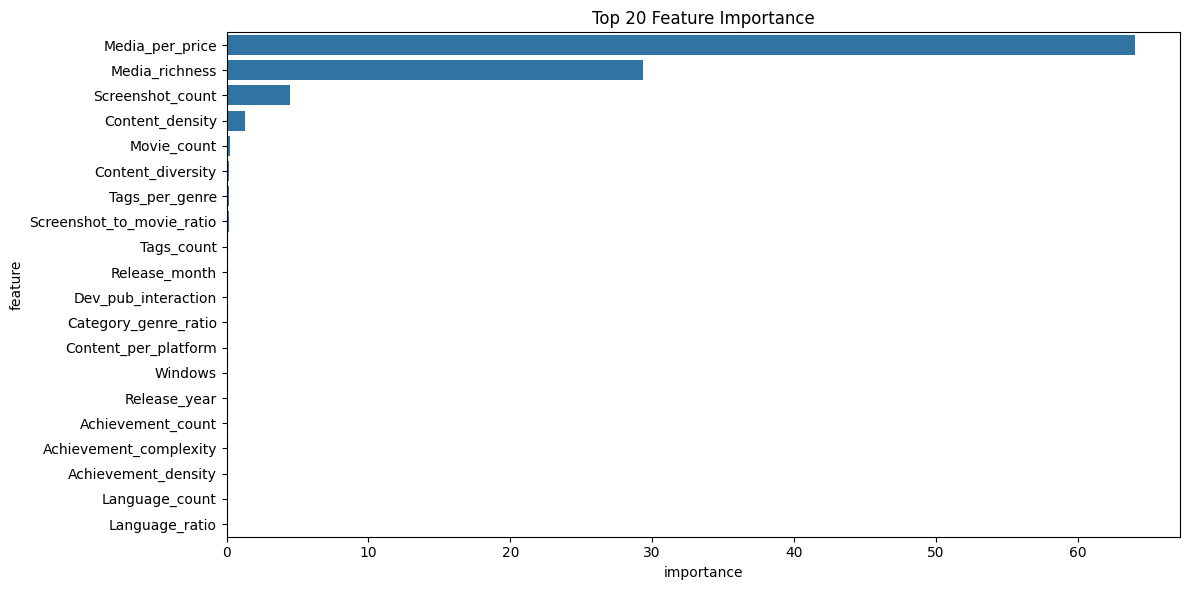

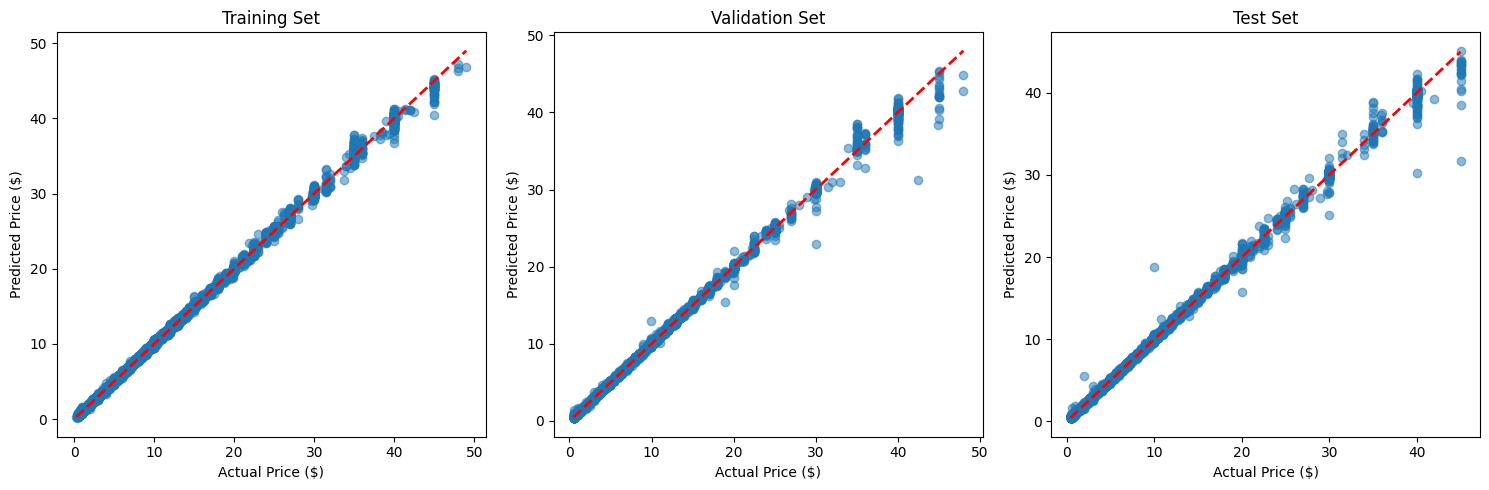

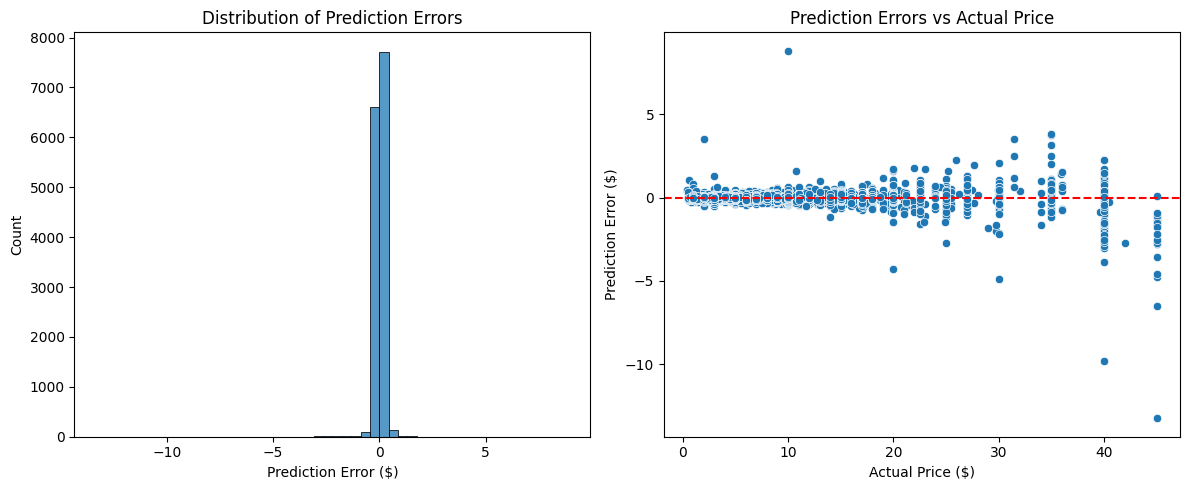


價格區間預測分析:
            abs_error              actual
                 mean   std  count   mean
price_range                              
0-10             0.05  0.11  11265   4.62
10-20            0.13  0.16   2652  15.52
20-30            0.33  0.40    551  26.87
30-50            1.07  1.50    192  38.83
50-100            NaN   NaN      0    NaN
100+              NaN   NaN      0    NaN


<ipython-input-2-922808ea479e>:172: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  analysis = df.groupby('price_range').agg({


In [ ]:
# 安裝必要的套件
!pip install catboost

import json
import pandas as pd
import numpy as np
from catboost import CatBoost, Pool
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 載入資料
def load_json_data(filename):
    with open(filename, 'r', encoding='utf-8') as f:
        return pd.DataFrame.from_dict(json.load(f), orient='index')

train_data = load_json_data('train_data.json')
val_data = load_json_data('val_data.json')
test_data = load_json_data('test_data.json')

# 2. 準備特徵和目標變數
target = 'Price'
features_to_drop = ['Developer_encoded', 'Publisher_encoded']
features = [col for col in train_data.columns if col not in [target] + features_to_drop]

X_train = train_data[features]
y_train = train_data[target]
X_val = val_data[features]
y_val = val_data[target]
X_test = test_data[features]
y_test = test_data[target]

print("特徵數量:", len(features))
print("訓練集大小:", X_train.shape)
print("驗證集大小:", X_val.shape)
print("測試集大小:", X_test.shape)

# 3. 建立 CatBoost 資料集
train_pool = Pool(X_train, y_train)
val_pool = Pool(X_val, y_val)
test_pool = Pool(X_test, y_test)

# 4. 設定模型參數
model_params = {
    'iterations': 1000,
    'learning_rate': 0.07,
    'depth': 8,
    'l2_leaf_reg': 12,
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
    'random_seed': 42,
    'early_stopping_rounds': 50,
    'verbose': 100
}

# 5. 訓練模型
model = CatBoost(params=model_params)
print("開始訓練模型...")

model.fit(
    train_pool,
    eval_set=val_pool,
    plot=True  # Colab 中可以顯示訓練過程圖
)

# 6. 模型評估
def evaluate_model(model, X, y, dataset_name):
    predictions = model.predict(X)
    rmse = np.sqrt(mean_squared_error(y, predictions))
    mae = mean_absolute_error(y, predictions)
    r2 = r2_score(y, predictions)

    print(f"\n{dataset_name} 評估結果:")
    print(f"RMSE: ${rmse:.2f}")
    print(f"MAE: ${mae:.2f}")
    print(f"R2 Score: {r2:.4f}")
    return predictions, rmse, mae, r2

# 在所有資料集上進行評估
train_pred, train_rmse, train_mae, train_r2 = evaluate_model(model, X_train, y_train, "訓練集")
val_pred, val_rmse, val_mae, val_r2 = evaluate_model(model, X_val, y_val, "驗證集")
test_pred, test_rmse, test_mae, test_r2 = evaluate_model(model, X_test, y_test, "測試集")

# 7. 特徵重要性分析
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(20))
plt.title('Top 20 Feature Importance')
plt.tight_layout()
plt.show()

# 8. 預測值與實際值的比較
plt.figure(figsize=(15, 5))

# 訓練集
plt.subplot(131)
plt.scatter(y_train, train_pred, alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Actual Price ($)')
plt.ylabel('Predicted Price ($)')
plt.title('Training Set')

# 驗證集
plt.subplot(132)
plt.scatter(y_val, val_pred, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('Actual Price ($)')
plt.ylabel('Predicted Price ($)')
plt.title('Validation Set')

# 測試集
plt.subplot(133)
plt.scatter(y_test, test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price ($)')
plt.ylabel('Predicted Price ($)')
plt.title('Test Set')

plt.tight_layout()
plt.show()

# 9. 預測誤差分析
test_errors = test_pred - y_test

plt.figure(figsize=(12, 5))
plt.subplot(121)
sns.histplot(test_errors, bins=50)
plt.title('Distribution of Prediction Errors')
plt.xlabel('Prediction Error ($)')
plt.ylabel('Count')

plt.subplot(122)
sns.scatterplot(x=y_test, y=test_errors)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Prediction Errors vs Actual Price')
plt.xlabel('Actual Price ($)')
plt.ylabel('Prediction Error ($)')

plt.tight_layout()
plt.show()

# 10. 儲存模型和結果
model.save_model('catboost_model.cbm')

# 儲存評估結果
results = {
    'model_parameters': model_params,
    'metrics': {
        'train': {'rmse': train_rmse, 'mae': train_mae, 'r2': train_r2},
        'validation': {'rmse': val_rmse, 'mae': val_mae, 'r2': val_r2},
        'test': {'rmse': test_rmse, 'mae': test_mae, 'r2': test_r2}
    },
    'feature_importance': feature_importance.head(20).to_dict('records')
}

with open('catboost_results.json', 'w') as f:
    json.dump(results, f, indent=4)

# 11. 價格區間預測準確度分析
def analyze_predictions_by_price_range(actual, predicted):
    df = pd.DataFrame({'actual': actual, 'predicted': predicted})
    df['abs_error'] = abs(df['actual'] - df['predicted'])
    df['price_range'] = pd.cut(df['actual'],
                              bins=[0, 10, 20, 30, 50, 100, float('inf')],
                              labels=['0-10', '10-20', '20-30', '30-50', '50-100', '100+'])

    analysis = df.groupby('price_range').agg({
        'abs_error': ['mean', 'std', 'count'],
        'actual': 'mean'
    }).round(2)

    return analysis

price_range_analysis = analyze_predictions_by_price_range(y_test, test_pred)
print("\n價格區間預測分析:")
print(price_range_analysis)

In [ ]:
from catboost import CatBoostRegressor # Import CatBoostRegressor

loaded_model = CatBoostRegressor()
loaded_model.load_model("catboost_model.cbm")

特徵與目標變數 'Price' 的相關性:
Price                        1.000000
Media_richness               0.283393
Movie_count                  0.248663
Screenshot_count             0.248615
Content_diversity            0.212928
Categories_count             0.196028
Language_count               0.189518
Category_genre_ratio         0.184978
Content_per_platform         0.178211
Tags_count                   0.176541
Language_diversity_score     0.176293
Tags_per_genre               0.175186
Language_coverage            0.168487
Features_score               0.164379
Audio_language_count         0.160594
Achievement_complexity       0.130022
Achievement_count            0.123061
Language_ratio               0.096601
Has_achievements             0.063741
Screenshot_to_movie_ratio    0.058032
Mac                          0.033468
Platform_diversity           0.020853
Platform_count               0.020820
Release_year                 0.012886
Release_month                0.011007
Season_Spring               

<ipython-input-16-4e565c9481c5>:31: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-16-4e565c9481c5>:31: UserWarning: Glyph 24501 (\N{CJK UNIFIED IDEOGRAPH-5FB5}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-16-4e565c9481c5>:31: UserWarning: Glyph 30456 (\N{CJK UNIFIED IDEOGRAPH-76F8}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-16-4e565c9481c5>:31: UserWarning: Glyph 38364 (\N{CJK UNIFIED IDEOGRAPH-95DC}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-16-4e565c9481c5>:31: UserWarning: Glyph 24615 (\N{CJK UNIFIED IDEOGRAPH-6027}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-16-4e565c9481c5>:31: UserWarning: Glyph 29105 (\N{CJK UNIFIED IDEOGRAPH-71B1}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-16-4e565c9481c5>:31: UserWarning: Glyph 22294 (\N{CJK UNIFIED IDEOGRAPH-5716}) missing from

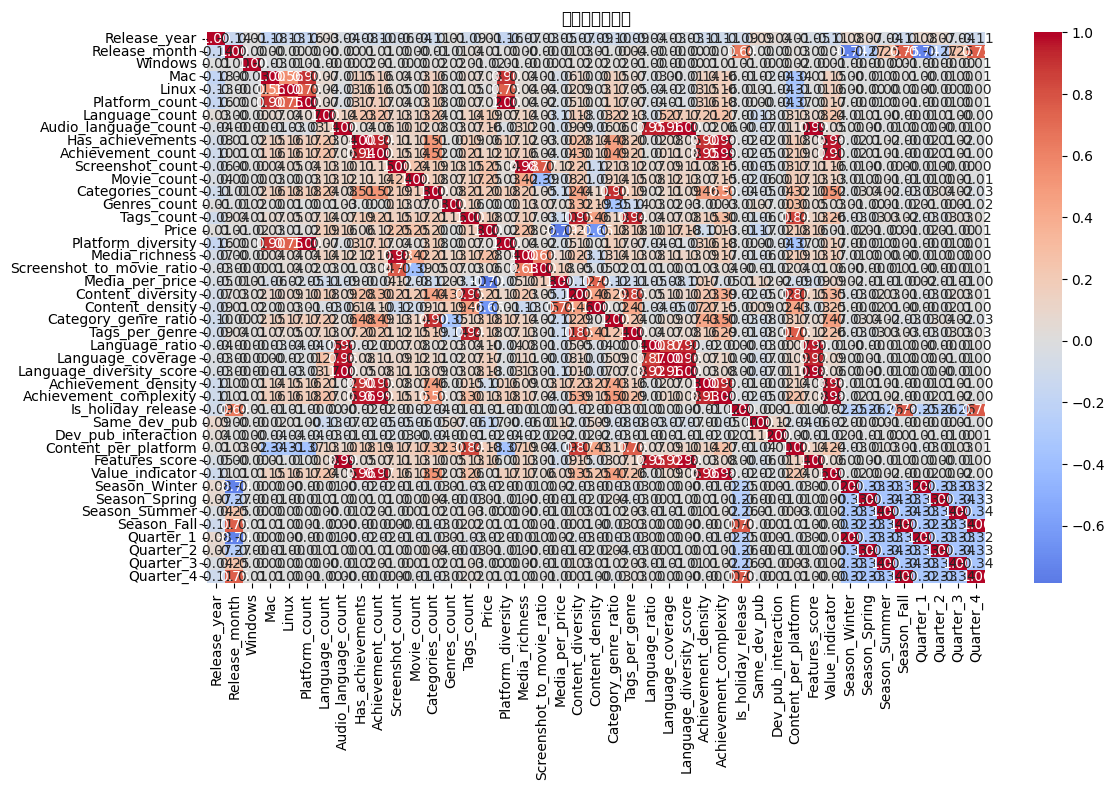

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json

# Load the data again since it's not in the current scope
def load_json_data(filename):
    with open(filename, 'r', encoding='utf-8') as f:
        return pd.DataFrame.from_dict(json.load(f), orient='index')

train_data = load_json_data('train_data.json') # Load the data here

# Assuming 'train_data' from your previous cell contains the data
# Replace 'train_data' with the actual DataFrame you want to use
df = train_data

# 計算相關係數矩陣
correlation_matrix = df.corr()

# 提取目標變數 'Price' 的相關性
price_correlation = correlation_matrix['Price'].sort_values(ascending=False)

# 輸出相關性
print("特徵與目標變數 'Price' 的相關性:")
print(price_correlation)

# 可視化相關性矩陣
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, annot=True, fmt=".2f")
plt.title('特徵相關性熱圖')
plt.tight_layout()
plt.show()